## Preprocess DataFrame and Handle Categorical Features for Clustering

Project Goal: Cluster users together to recommend songs.

This notebook focuses on preprocessing the `users_df` for clustering. The steps taken include:

*   **Handling Missing Values:** Rows with NaN values were dropped.
*   **Outlier Consideration and Scaling:** Instead of dropping users based on a play count cutoff, numerical features were scaled using `RobustScaler`, which is less sensitive to outliers than `MinMaxScaler` or `StandardScaler`. We did because we think there is value in knowing the preferred songs of power users.
*   **Categorical Feature Encoding:** We explored one-hot encoding for categorical features. Due to the high number of unique values in 'fav\_song' (over 119,000 unique values) and 'fav\_artist' (over 14,000 unique values), one-hot encoding both of these columns is not feasible due to memory constraints. We decided on only encoding 'fav\_artist'. We identified that 'fav\_maj\_genre' and 'fav\_min\_genre' have manageable unique values for one-hot encoding.

The preprocessed data, `users_df_encoded` (which includes our transformations), is now prepared for further analysis, such as dimensionality reduction with PCA and subsequent K-Means clustering. We save this processed df to our drive so that we can logically separate notebooks and not recompute.

### Load Data

In [ ]:
!pip install pyarrow  # to save data to a parquet file

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
users_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_cleaned_df.parquet"

In [ ]:
users_polars_df = pl.read_parquet(processed_users_path)

In [ ]:
users_df_original = users_polars_df.to_pandas(use_pyarrow_extension_array=True)
users_df = users_df_original.copy()

### EDA and preprocessing
We thought we would drop outlier users but decided against it and went for a scaler that accounts for outliers. We include some of our EDA.

In [ ]:
users_df[users_df['user_id'] == '093cb74eb3c517c5179ae24caf0ebec51b24d2a2']

,user_id,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_genre,fav_maj_count,fav_min_genre,fav_min_count,fav_year,year_count,fav_artist,fav_artist_plays,fav_song,fav_song_plays,fav_song_duration,tot_fav_song_play_time
33488,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,11697,2.408770e+06,98,98,Rock,39,Rock,8,2009,17,AR4DW2Q1187FB44DB6,3,SOAOSDF12A58A779F1,9667,201.56036,1.948484e+06


In [ ]:
users_df = users_df.dropna()

In [ ]:
users_df.describe()

,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,933431.000000,9.334310e+05,933431.000000,933431.000000,933431.000000,933431.000000,933431.000000,933431.000000,933431.000000,933431.000000,933431.000000,9.334310e+05
mean,75.072520,1.860510e+04,27.352648,27.352648,15.393956,3.465819,2001.049530,5.766003,5.351766,12.863076,250.970620,3.232460e+03
std,106.195572,2.630841e+04,35.009184,35.009184,21.173470,4.441338,10.043838,5.842962,5.855139,24.700324,88.089775,6.284949e+03
min,1.000000,5.289751e+01,1.000000,1.000000,1.000000,1.000000,1924.000000,1.000000,1.000000,1.000000,1.122810,1.122810e+00
25%,17.000000,4.263698e+03,9.000000,9.000000,4.000000,1.000000,1999.000000,2.000000,2.000000,3.000000,202.579140,7.644455e+02
50%,39.000000,9.661946e+03,15.000000,15.000000,8.000000,2.000000,2005.000000,4.000000,3.000000,7.000000,237.792200,1.658510e+03
75%,90.000000,2.224083e+04,32.000000,32.000000,18.000000,4.000000,2008.000000,7.000000,7.000000,15.000000,280.972610,3.603012e+03
max,11697.000000,2.408770e+06,2365.000000,2365.000000,1411.000000,216.000000,2010.000000,267.000000,80.000000,9667.000000,2328.110570,1.948484e+06


<Axes: title={'center': 'fav_song_duration'}, ylabel='Frequency'>

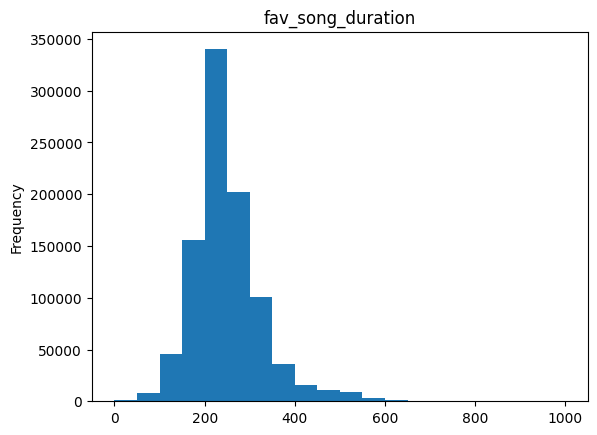

In [ ]:
hist_var = 'fav_song_duration'  #"unqiue_song_count"#'fav_song_duration'
users_df[hist_var].plot(
    kind='hist',
    bins=20,
    title=hist_var,
    range=(0, 1000)  # min is 10
)

#### Filter Data

In [ ]:
#playlists are generated for users who listen to more than 10 different songs (i.e the size of our playlist)
# we can just recommend generic songs to users that don't or are new
filtered_users_df = users_df[users_df['unqiue_song_count'] > 10]
#we only sonsider user that like listening to tracks/songs that are more than 30 seconds and less than 10 minutes
filtered_users_df = filtered_users_df[filtered_users_df['fav_song_duration'] > 30]
filtered_users_df = filtered_users_df[filtered_users_df['fav_song_duration'] < 600]
filtered_users_df = filtered_users_df[filtered_users_df['total_play_time'] < 70000]
filtered_users_df = filtered_users_df[filtered_users_df['total_play_count'] < 5000]
filtered_users_df = filtered_users_df[filtered_users_df['total_play_count'] > 10]

len(filtered_users_df)


574660

In [ ]:
users_df = filtered_users_df


In [ ]:
users_df = users_df[users_df['total_play_count'] < 200]
users_df = users_df[users_df['total_play_count'] > 24]
users_df = users_df[users_df['unqiue_song_count'] > 15]
users_df = users_df[users_df['fav_year'] > 2000]
users_df = users_df[users_df['total_play_time'] < 70000]


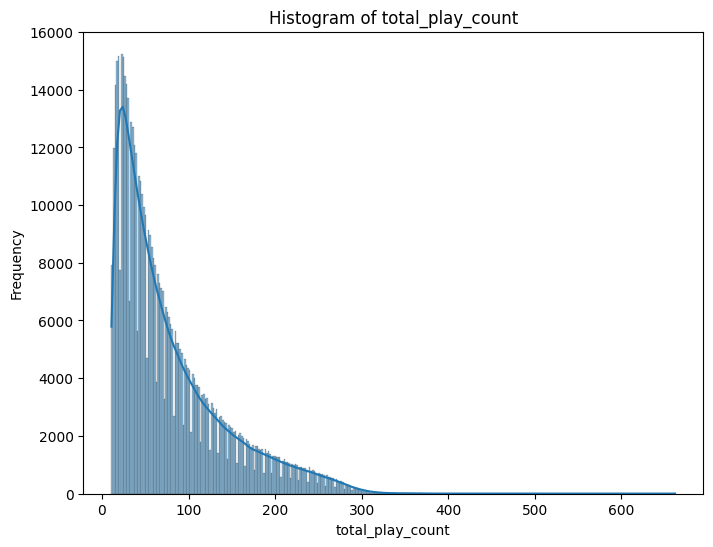

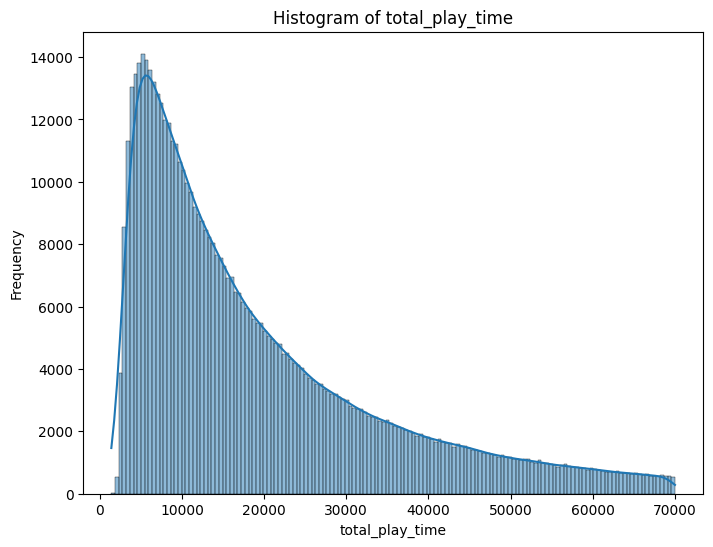

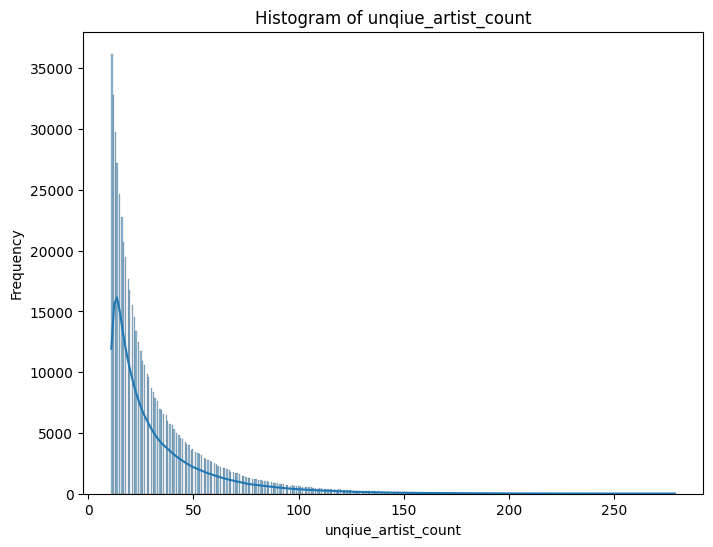

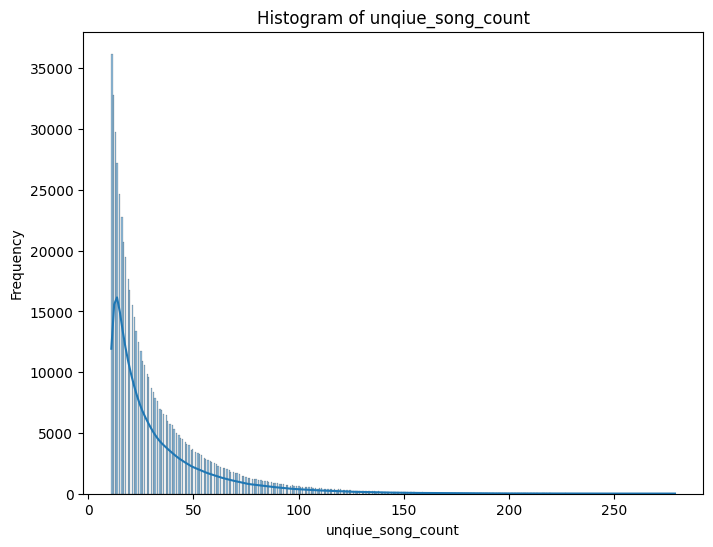

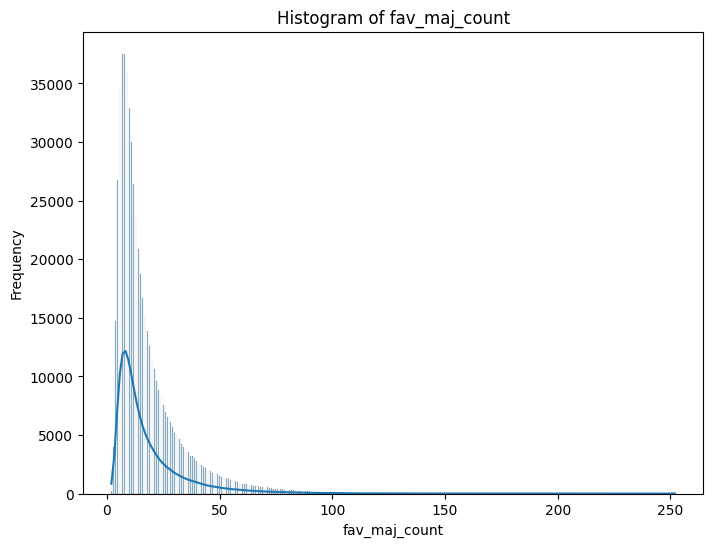

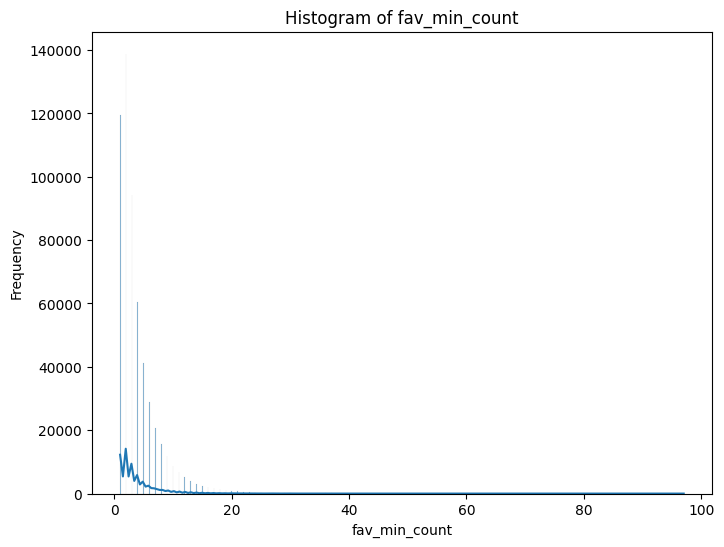

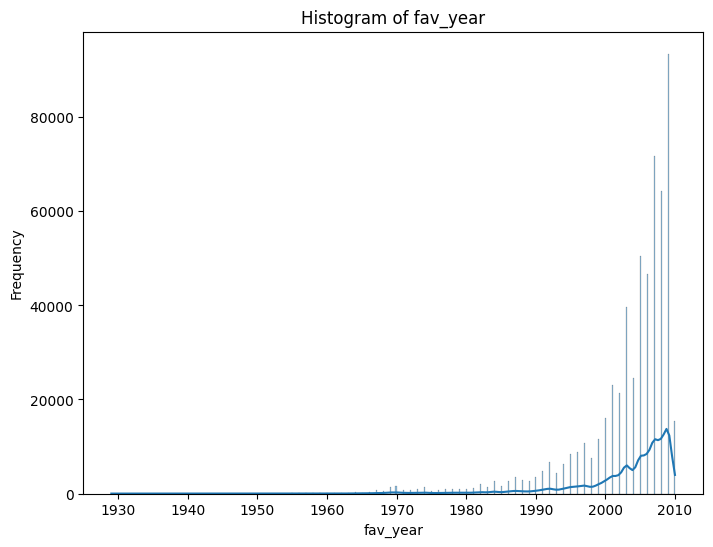

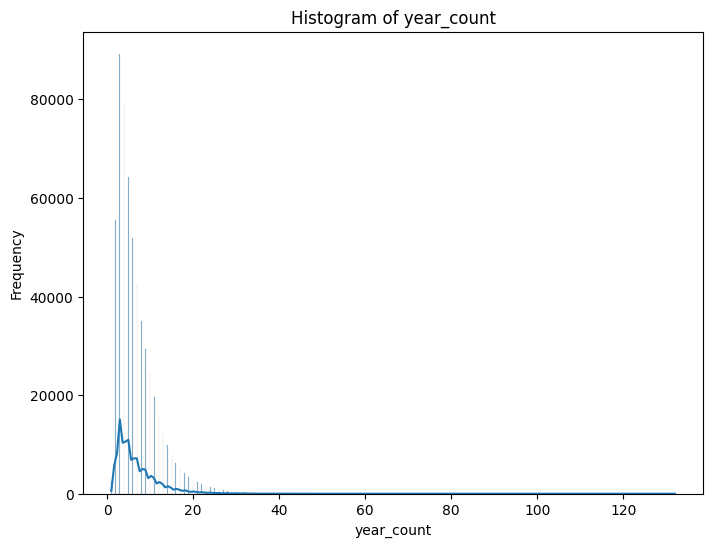

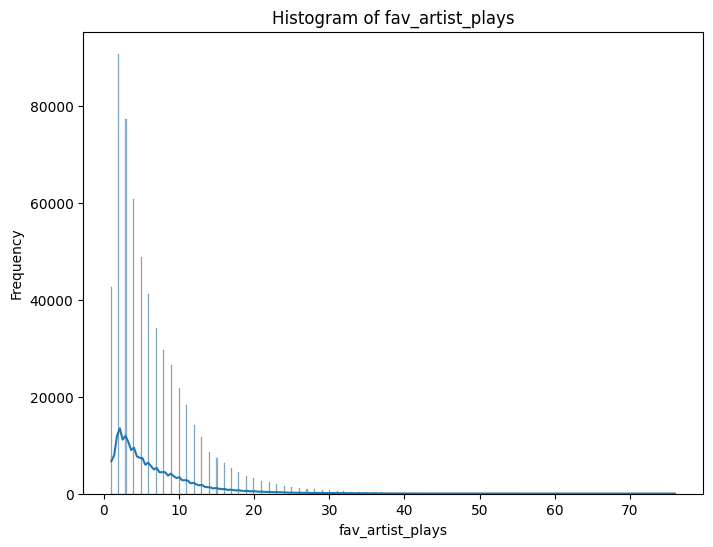

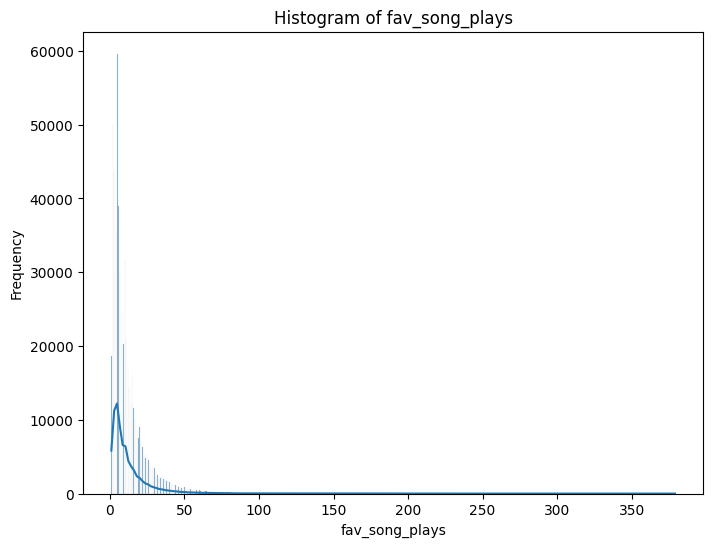

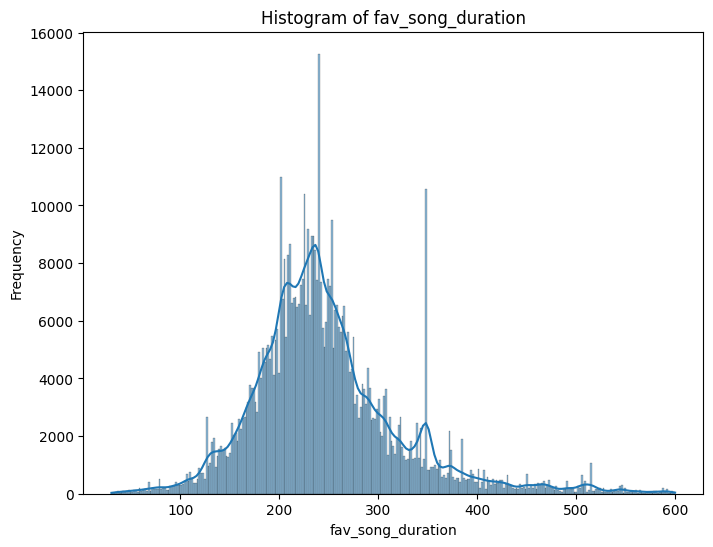

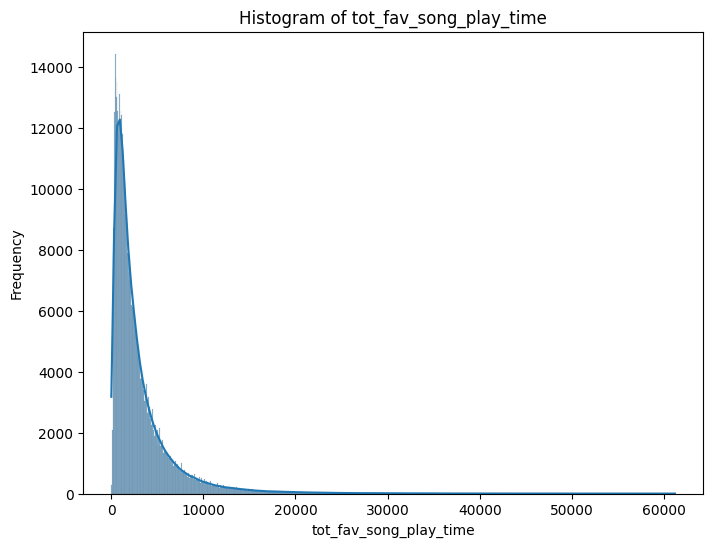

In [ ]:
numerical_cols = filtered_users_df.select_dtypes(include=np.number).columns

for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(filtered_users_df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

#### Scaling Numerical Features

After deciding not to drop users based on play count, we focused on scaling numerical features. We found `MinMaxScaler` was heavily influenced by outliers, compressing most data into a small range with a low mean. Based on scikit-learn documentation, we selected `RobustScaler` as it uses robust statistics (median and interquartile range) and is less sensitive to outliers, making it more suitable for our dataset.

In [ ]:
# Select numerical columns to normalize and standardize
numerical_cols = users_df.select_dtypes(include=['number']).columns

# Initialize scalers
scaler_minmax = MinMaxScaler()
scaler_robust = RobustScaler()

# Apply minmax scaling
users_df_normalized = users_df.copy()
users_df_normalized[numerical_cols] = scaler_minmax.fit_transform(users_df_normalized[numerical_cols])

# Apply robust scaling
users_df_robustscaled = users_df.copy()
users_df_robustscaled[numerical_cols] = scaler_robust.fit_transform(users_df_robustscaled[numerical_cols])

print("Original Data:")
display(users_df[numerical_cols].describe())

print("MinMax Data:")
display(users_df_normalized[numerical_cols].describe())

print("Robust Scaled Data:")
display(users_df_robustscaled[numerical_cols].describe())

Original Data:


,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000
mean,78.400265,19304.523080,32.498768,32.498768,18.278314,4.021312,2003.119210,6.897244,6.573811,12.415489,247.257010,3058.560169
std,61.965175,15203.468226,25.802515,25.802515,16.213414,3.986638,7.571616,4.937461,5.751320,14.235372,75.182745,3651.121091
min,11.000000,1414.630100,11.000000,11.000000,2.000000,1.000000,1929.000000,1.000000,1.000000,1.000000,30.353830,31.712200
25%,31.000000,7690.539502,15.000000,15.000000,8.000000,2.000000,2001.000000,3.000000,3.000000,4.000000,201.795460,963.707560
50%,58.000000,14276.296805,23.000000,23.000000,13.000000,3.000000,2006.000000,5.000000,5.000000,8.000000,236.877910,1882.378905
75%,107.000000,26507.196050,40.000000,40.000000,22.000000,5.000000,2008.000000,9.000000,9.000000,15.000000,277.968530,3732.943365
max,662.000000,69998.626870,279.000000,279.000000,252.000000,97.000000,2010.000000,132.000000,76.000000,379.000000,599.718730,61144.907620


MinMax Data:


,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000
mean,0.103533,0.260846,0.080219,0.080219,0.065113,0.031472,0.915052,0.045017,0.074317,0.030200,0.380956,0.049529
std,0.095185,0.221677,0.096278,0.096278,0.064854,0.041527,0.093477,0.037691,0.076684,0.037660,0.132047,0.059744
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.030722,0.091507,0.014925,0.014925,0.024000,0.010417,0.888889,0.015267,0.026667,0.007937,0.301110,0.015250
50%,0.072197,0.187532,0.044776,0.044776,0.044000,0.020833,0.950617,0.030534,0.053333,0.018519,0.362727,0.030283
75%,0.147465,0.365866,0.108209,0.108209,0.080000,0.041667,0.975309,0.061069,0.106667,0.037037,0.434896,0.060564
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Robust Scaled Data:


,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000,574660.000000
mean,0.268425,0.267222,0.379951,0.379951,0.377022,0.340437,-0.411541,0.316207,0.262302,0.401408,0.136257,0.424731
std,0.815331,0.807979,1.032101,1.032101,1.158101,1.328879,1.081659,0.822910,0.958553,1.294125,0.986999,1.318458
min,-0.618421,-0.683526,-0.480000,-0.480000,-0.785714,-0.666667,-11.000000,-0.666667,-0.666667,-0.636364,-2.711248,-0.668295
25%,-0.355263,-0.349996,-0.320000,-0.320000,-0.357143,-0.333333,-0.714286,-0.333333,-0.333333,-0.363636,-0.460562,-0.331742
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.644737,0.650004,0.680000,0.680000,0.642857,0.666667,0.285714,0.666667,0.666667,0.636364,0.539438,0.668258
max,7.947368,2.961330,10.240000,10.240000,17.071429,31.333333,0.571429,21.166667,11.833333,33.727273,4.763374,21.400319


One hot encode categorical data

The number of unique favorite arists: 14,975. This is manageable.

The number of unique favorite songs is 119,417. This takes too much RAM.

In [ ]:
# Count unique categorical values
num_unique_artists = users_df['fav_artist'].nunique()
num_unique_songs = users_df['fav_song'].nunique()  # too many
num_unique_maj_genres = users_df['fav_maj_genre'].nunique()
num_unique_min_genres = users_df['fav_min_genre'].nunique()

print(f"Number of unique favorite artists: {num_unique_artists}")
print(f"Number of unique favorite songs: {num_unique_songs}")
print(f"Number of unique favorite major genres: {num_unique_maj_genres}")
print(f"Number of unique favorite minority genres: {num_unique_min_genres}")

Number of unique favorite artists: 8250
Number of unique favorite songs: 61155
Number of unique favorite major genres: 15
Number of unique favorite minority genres: 15


In [ ]:
# Select categorical columns for one-hot encoding
# ['fav_song'] a ton of these guys = run out of ram if try to use so omit
users_df_robustscaled = users_df_robustscaled.drop(columns=["fav_song"])
# Features to do one-hot encoding on
categorical_cols = ['fav_maj_genre', 'fav_min_genre', 'fav_artist']
users_df_encoded = pd.get_dummies(users_df_robustscaled, columns=categorical_cols, dummy_na=False)

print("Original DataFrame shape:", users_df_robustscaled.shape)
print("DataFrame shape after one-hot encoding:", users_df_encoded.shape)
display(users_df_encoded.head())

Original DataFrame shape: (574660, 16)
DataFrame shape after one-hot encoding: (574660, 8293)


,user_id,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,...,fav_artist_ARZXTEY1187B9997A7,fav_artist_ARZXZ731187B9B8813,fav_artist_ARZYJO61187B98F4B9,fav_artist_ARZYPLF1187FB45B9B,fav_artist_ARZYRP21187FB53526,fav_artist_ARZYSCW1187FB52DF7,fav_artist_ARZYT8C1187FB4D57F,fav_artist_ARZYZUU11F4C841DCC,fav_artist_ARZZLLI1187B99C8DD,fav_artist_ARZZMWO1187B9AFB36
3,00001cf0dce3fb22b0df0f3a1d9cd21e38385372,-0.526316,-0.525042,-0.48,-0.48,-0.214286,0.000000,0.428571,0.166667,0.000000,...,False,False,False,False,False,False,False,False,False,False
4,0000267bde1b3a70ea75cf2b2d216cb828e3202b,-0.513158,-0.485083,-0.20,-0.20,0.000000,0.666667,0.000000,-0.166667,-0.500000,...,False,False,False,False,False,False,False,False,False,False
6,00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e,-0.039474,-0.106965,0.44,0.44,1.428571,-0.666667,0.285714,0.833333,3.000000,...,False,False,False,False,False,False,False,False,False,False
8,000060ca4e6bea0a5c9037fc1bbd7bbabb98c754,-0.473684,-0.460736,-0.40,-0.40,-0.214286,-0.333333,-1.428571,-0.500000,-0.666667,...,False,False,False,False,False,False,False,False,False,False
9,00007ed2509128dcdd74ea3aac2363e24e9dc06b,-0.263158,-0.238498,0.36,0.36,0.928571,0.333333,-0.285714,0.500000,2.000000,...,False,False,False,False,False,False,False,False,False,False


### Save processed dataframe

In [ ]:
# if local
processed_users_path_parquet = "data/users_cleaned_df_encoded.parquet"

In [ ]:
# # if collab
# "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_cleaned_df_encoded.parquet"

In [ ]:
# Save the processed dataframe to Parquet
users_df_encoded.to_parquet(processed_users_path_parquet, index=False, engine='pyarrow')
print(f"Processed DataFrame saved to: {processed_users_path_parquet}")

Processed DataFrame saved to: /content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_cleaned_df_encoded.parquet
